In [4]:
!pip install openmeteo_requests retry_requests requests_cache

In [7]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# --- 1. CONFIGURATION ---
# On définit les variables ici pour s'assurer que l'ordre de requête
# correspond exactement à l'ordre d'extraction.
HOURLY_VARS = [
    "temperature_2m", "rain", "precipitation", "precipitation_probability",
    "apparent_temperature", "relative_humidity_2m", "wind_speed_10m",
    "wind_gusts_10m", "wind_direction_10m", "weather_code", "cloud_cover",
    "visibility", "showers", "snowfall", "uv_index", "uv_index_clear_sky", "is_day"
]

DAILY_VARS = [
    "sunrise", "sunset", "daylight_duration", "sunshine_duration"
]

CURRENT_VARS = [
    "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "precipitation",
    "rain", "showers", "snowfall", "temperature_2m", "apparent_temperature",
    "relative_humidity_2m", "is_day", "weather_code", "cloud_cover",
    "pressure_msl", "surface_pressure"
]

# --- 2. COUCHE D'EXTRACTION (FETCH) ---
def fetch_openmeteo_response(latitude, longitude):
    """Gère uniquement la connexion à l'API, le cache et les retries."""
    # Setup cache
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "daily": DAILY_VARS,
        "hourly": HOURLY_VARS,
        "current": CURRENT_VARS,
        "timezone": "auto",
    }

    # On retourne la réponse brute de l'objet OpenMeteo
    responses = openmeteo.weather_api(url, params=params)
    return responses[0]


# --- 3. COUCHE DE TRAITEMENT (PARSING) ---
def process_hourly(response):
    """Transforme les données horaires brutes en DataFrame Pandas."""
    hourly = response.Hourly()

    # Création de l'axe temporel
    date_range = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    data = {"date": date_range}

    # Extraction dynamique basée sur la liste HOURLY_VARS
    for i, var_name in enumerate(HOURLY_VARS):
        data[var_name] = hourly.Variables(i).ValuesAsNumpy()

    df = pd.DataFrame(data)

    # Conversion locale du timezone si besoin (optionnel)
    # df['date'] = df['date'].dt.tz_convert('Europe/Paris')

    return df

def process_daily(response):
    """Transforme les données quotidiennes brutes en DataFrame Pandas."""
    daily = response.Daily()

    date_range = pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )

    data = {"date": date_range}

    for i, var_name in enumerate(DAILY_VARS):
        # Gestion spécifique pour les timestamps (lever/coucher du soleil)
        val = daily.Variables(i).ValuesAsNumpy() if var_name not in ['sunrise', 'sunset'] \
              else daily.Variables(i).ValuesInt64AsNumpy()
        data[var_name] = val

    df = pd.DataFrame(data)

    # Conversion des colonnes timestamps en datetime lisible
    for col in ['sunrise', 'sunset']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], unit='s', utc=True)

    return df

def process_current(response):
    """Extrait les données actuelles sous forme de dictionnaire simple."""
    current = response.Current()

    data = {
        "timestamp": pd.to_datetime(current.Time(), unit='s', utc=True),
        "latitude": response.Latitude(),
        "longitude": response.Longitude(),
        "timezone": response.Timezone()
    }

    for i, var_name in enumerate(CURRENT_VARS):
        data[var_name] = current.Variables(i).Value()

    return data

# --- 4. FONCTION PRINCIPALE (FACADE) ---
def get_weather_analysis_ready(latitude, longitude):
    """
    Fonction principale à appeler.
    Retourne un dictionnaire contenant des DataFrames prêts pour l'analyse.
    """
    print(f"📡 Récupération des données pour {latitude}, {longitude}...")
    response = fetch_openmeteo_response(latitude, longitude)

    return {
        "current": process_current(response),
        "hourly": process_hourly(response), # C'est un DataFrame
        "daily": process_daily(response)    # C'est un DataFrame
    }

In [8]:
# --- 1. Récupération et Préparation (Rappel) ---
weather_data = get_weather_analysis_ready(48.8566, 2.3522)
df_hourly = pd.DataFrame(weather_data['hourly'])
df_daily = pd.DataFrame(weather_data['daily'])

# Conversion des dates
df_hourly['date'] = pd.to_datetime(df_hourly['date'])
df_daily['date'] = pd.to_datetime(df_daily['date'])

# --- 2. Indicateurs Globaux (Sur toute la période) ---
print("--- 📊 RÉSUMÉ GLOBAL (Sur toute la période) ---")

# Calculs de base sur la température et le vent
stats_globales = {
    "Température Moyenne (°C)": df_hourly['temperature_2m'].mean(),
    "Température Max Absolue (°C)": df_hourly['temperature_2m'].max(),
    "Température Min Absolue (°C)": df_hourly['temperature_2m'].min(),
    "Vent Moyen (km/h)": df_hourly['wind_speed_10m'].mean(),
    "Rafale Max (km/h)": df_hourly['wind_gusts_10m'].max(),
    "Pluie Totale (mm)": df_hourly['precipitation'].sum(), # Somme des pluies horaires
    "Heures de pluie": (df_hourly['precipitation'] > 0).sum() # Nombre d'heures où il pleut
}

for k, v in stats_globales.items():
    print(f"{k:<30} : {v:.2f}")

print("\n")

# --- 3. Indicateurs "Jour vs Nuit" ---
# C'est très utile pour voir l'amplitude thermique
print("--- 🌞 vs 🌙 JOUR / NUIT ---")
day_night_stats = df_hourly.groupby('is_day')[['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m']].mean()
day_night_stats.index = ['Nuit', 'Jour'] # On renomme 0 et 1
print(day_night_stats.round(2))

print("\n")

# --- 4. Analyse Quotidienne (Agrégée par jour) ---
# On crée un nouveau tableau qui résume chaque journée
print("--- 📅 ANALYSE QUOTIDIENNE (Extrait) ---")

df_synthese_jour = df_hourly.set_index('date').resample('D').agg({
    'temperature_2m': ['min', 'max', 'mean'],      # Min, Max et Moyenne de temp
    'precipitation': 'sum',                        # Total de pluie par jour
    'wind_gusts_10m': 'max',                       # Rafale max du jour
    'uv_index': 'max',                             # UV max du jour
    'relative_humidity_2m': 'mean'                 # Humidité moyenne
})

# On aplatit les noms de colonnes pour que ce soit plus propre (ex: temperature_2m_mean)
df_synthese_jour.columns = ['_'.join(col).strip() for col in df_synthese_jour.columns.values]

# Affichage des 5 premiers jours
print(df_synthese_jour.head().round(2))

print("\n")

# --- 5. La "Volatilité" (Écart-Type) ---
# Si ce chiffre est élevé, la météo est instable (change beaucoup)
print("--- 📉 STABILITÉ MÉTÉO (Écart-Type) ---")
std_dev = df_hourly[['temperature_2m', 'wind_speed_10m']].std()
print("Si ces chiffres sont élevés, la météo change beaucoup :")
print(std_dev.round(2))

# --- 6. Matrice de Corrélation (Qu'est-ce qui est lié ?) ---
print("\n--- 🔗 CORRÉLATIONS CLÉS ---")
# On regarde ce qui influence la température ressentie
correlation = df_hourly[['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m']].corr()
print(correlation.round(2))

📡 Récupération des données pour 48.8566, 2.3522...
--- 📊 RÉSUMÉ GLOBAL (Sur toute la période) ---
Température Moyenne (°C)       : 7.06
Température Max Absolue (°C)   : 13.20
Température Min Absolue (°C)   : 1.00
Vent Moyen (km/h)              : 11.25
Rafale Max (km/h)              : 51.12
Pluie Totale (mm)              : 6.80
Heures de pluie                : 22.00


--- 🌞 vs 🌙 JOUR / NUIT ---
      temperature_2m  relative_humidity_2m  wind_speed_10m
Nuit            6.56             87.349998           10.72
Jour            8.06             82.940002           12.31


--- 📅 ANALYSE QUOTIDIENNE (Extrait) ---
                           temperature_2m_min  temperature_2m_max  \
date                                                                
2025-11-30 00:00:00+00:00                4.82                4.82   
2025-12-01 00:00:00+00:00                2.36                7.86   
2025-12-02 00:00:00+00:00                6.26                8.92   
2025-12-03 00:00:00+00:00              

📡 Récupération des données pour 48.8566, 2.3522...
                      temperature_2m  relative_humidity_2m
temperature_2m              1.000000             -0.424937
relative_humidity_2m       -0.424937              1.000000


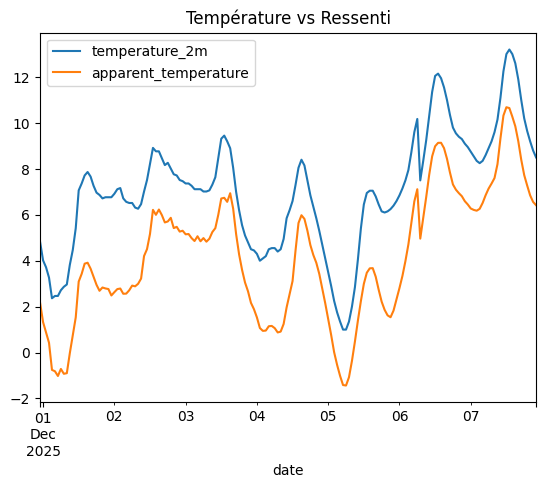

In [9]:
# 1. Récupérer les données
weather = get_weather_analysis_ready(48.8566, 2.3522)

# 2. Accéder aux DataFrames directement
df_h = weather['hourly']
df_d = weather['daily']

# 3. Analyse immédiate (exemple : corrélation)
print(df_h[['temperature_2m', 'relative_humidity_2m']].corr())

# 4. Plot rapide
import matplotlib.pyplot as plt
df_h.set_index('date')[['temperature_2m', 'apparent_temperature']].plot()
plt.title("Température vs Ressenti")
plt.show()

In [10]:
import pandas as pd

# 1. Tu appelles ta fonction normalement
weather_result = get_weather_analysis_ready(48.8566, 2.3522)

# 2. C'est ici que tu crées les variables df_hourly et df_daily
# On transforme la liste de dictionnaires en DataFrame
df_hourly = pd.DataFrame(weather_result['hourly'])
df_daily = pd.DataFrame(weather_result['daily'])

# 3. ÉTAPE TRÈS IMPORTANTE : Convertir la colonne "date"
# Ta fonction renvoie parfois des dates en texte (string),
# il faut les remettre en format "date" pour que les graphiques les comprennent.
df_hourly['date'] = pd.to_datetime(df_hourly['date'])
df_daily['date'] = pd.to_datetime(df_daily['date'])

# --- Maintenant, tu as df_hourly et df_daily, tu peux lancer les graphiques ! ---
print("Tout est prêt !")
print(df_hourly.head()) # Juste pour vérifier que ça marche

📡 Récupération des données pour 48.8566, 2.3522...
Tout est prêt !
                       date  temperature_2m  rain  precipitation  \
0 2025-11-30 23:00:00+00:00           4.815   0.0            0.0   
1 2025-12-01 00:00:00+00:00           4.015   0.0            0.0   
2 2025-12-01 01:00:00+00:00           3.715   0.0            0.0   
3 2025-12-01 02:00:00+00:00           3.265   0.0            0.0   
4 2025-12-01 03:00:00+00:00           2.365   0.0            0.0   

   precipitation_probability  apparent_temperature  relative_humidity_2m  \
0                        0.0              2.163283                  73.0   
1                        0.0              1.327517                  84.0   
2                        0.0              0.873013                  87.0   
3                        0.0              0.426590                  91.0   
4                        0.0             -0.755239                  91.0   

   wind_speed_10m  wind_gusts_10m  wind_direction_10m  weather_code

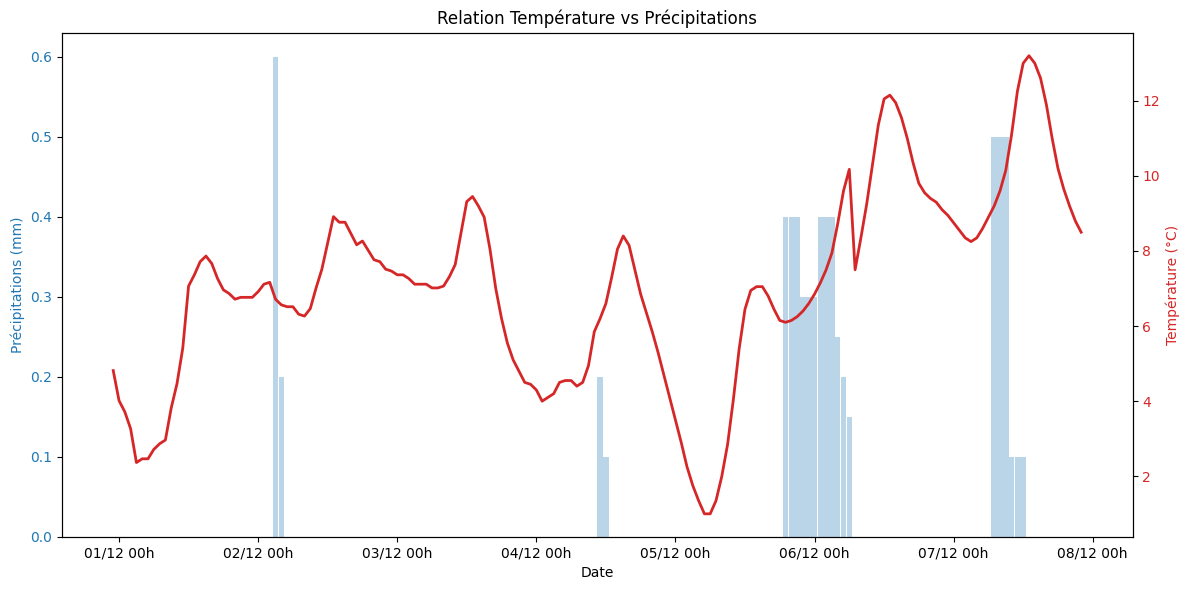

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe 1 : La pluie (Barres bleues)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Précipitations (mm)', color=color)
ax1.bar(df_hourly['date'], df_hourly['precipitation'], color=color, alpha=0.3, label='Pluie', width=0.04)
ax1.tick_params(axis='y', labelcolor=color)

# Axe 2 : La température (Ligne rouge) - on partage l'axe X
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Température (°C)', color=color)
ax2.plot(df_hourly['date'], df_hourly['temperature_2m'], color=color, linewidth=2, label='Température')
ax2.tick_params(axis='y', labelcolor=color)

# Formatage des dates pour que ce soit lisible
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
plt.title('Relation Température vs Précipitations')
fig.tight_layout()
plt.show()

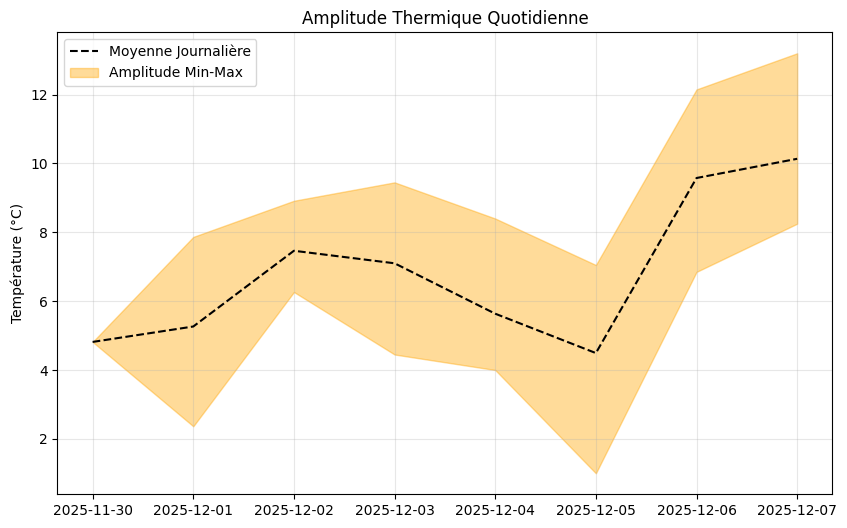

In [12]:
# Agrégation des données horaires par jour
daily_stats = df_hourly.set_index('date').resample('D')['temperature_2m'].agg(['min', 'max', 'mean'])

plt.figure(figsize=(10, 6))

# On trace la moyenne
plt.plot(daily_stats.index, daily_stats['mean'], color='black', linestyle='--', label='Moyenne Journalière')

# On remplit la zone entre le min et le max
plt.fill_between(daily_stats.index,
                 daily_stats['min'],
                 daily_stats['max'],
                 color='orange',
                 alpha=0.4,
                 label='Amplitude Min-Max')

plt.title('Amplitude Thermique Quotidienne')
plt.ylabel('Température (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 800x600 with 0 Axes>

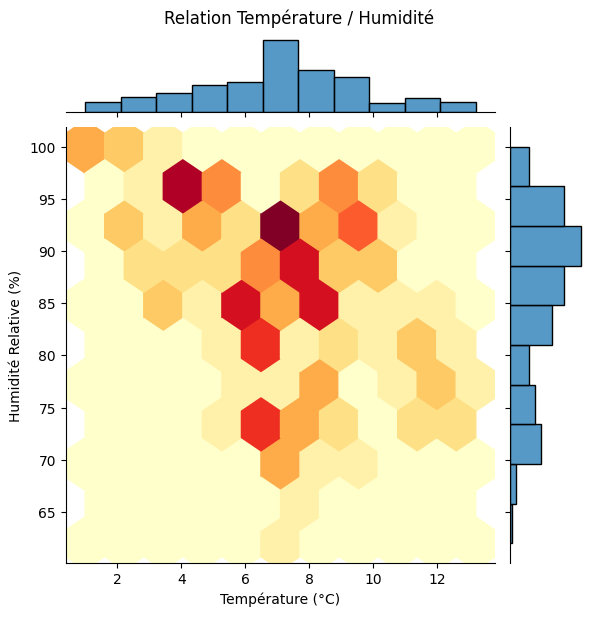

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 6))
# Jointplot permet de voir la distribution sur les côtés et le scatter au milieu
g = sns.jointplot(x='temperature_2m',
                  y='relative_humidity_2m',
                  data=df_hourly,
                  kind="hex",  # 'hex' crée des hexagones, très stylé pour la densité
                  cmap="YlOrRd")

g.set_axis_labels('Température (°C)', 'Humidité Relative (%)')
g.fig.suptitle('Relation Température / Humidité', y=1.02)
plt.show()

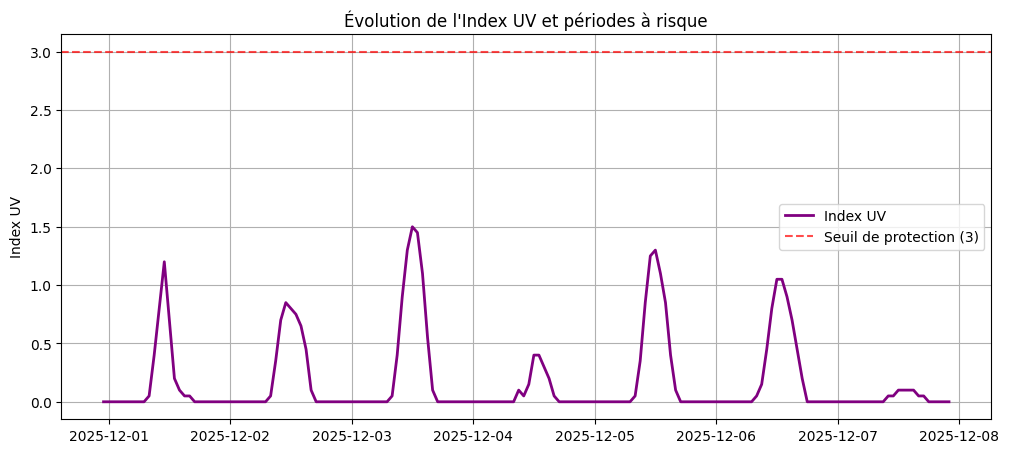

In [14]:
plt.figure(figsize=(12, 5))

# On trace l'index UV
plt.plot(df_hourly['date'], df_hourly['uv_index'], color='purple', linewidth=2, label='Index UV')

# On ajoute une ligne de danger (ex: UV > 3 = Protection requise)
plt.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Seuil de protection (3)')

# On colorie la zone dangereuse
plt.fill_between(df_hourly['date'], df_hourly['uv_index'], 3,
                 where=(df_hourly['uv_index'] >= 3),
                 interpolate=True, color='purple', alpha=0.3)

plt.title('Évolution de l\'Index UV et périodes à risque')
plt.ylabel('Index UV')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def degrees_to_cardinal(d):
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']
    ix = round(d / (360. / len(dirs)))
    return dirs[ix % len(dirs)]

# On applique la fonction sur la colonne direction
df_hourly['wind_cardinal'] = df_hourly['wind_direction_10m'].apply(degrees_to_cardinal)

print("--- 🌬️ DOMINANTE DU VENT ---")
# On compte combien d'heures le vent a soufflé depuis chaque direction
wind_counts = df_hourly['wind_cardinal'].value_counts()
print(wind_counts)

--- 🌬️ DOMINANTE DU VENT ---
wind_cardinal
S     112
SO     40
SE     10
O       6
Name: count, dtype: int64


In [16]:
print("\n--- 🕵️ AUDIT QUALITÉ DES DONNÉES ---")

# 1. Y a-t-il des trous dans les dates ? (Sauts temporels)
# On calcule la différence entre chaque ligne de date. Elle devrait être de 1 heure partout.
time_diff = df_hourly['date'].diff().dropna()
# Si on a autre chose que "0 days 01:00:00", c'est qu'il manque des heures
gaps = time_diff[time_diff != pd.Timedelta(hours=1)]

if gaps.empty:
    print("✅ Continuité temporelle parfaite (pas de trous).")
else:
    print(f"⚠️ ATTENTION : Il manque des données à {len(gaps)} endroits !")

# 2. Y a-t-il des valeurs impossibles ? (Ex: Humidité > 100% ou < 0%)
aberrations = df_hourly[ (df_hourly['relative_humidity_2m'] > 100) | (df_hourly['relative_humidity_2m'] < 0) ]
if aberrations.empty:
    print("✅ Pas d'aberrations détectées sur l'humidité.")
else:
    print(f"⚠️ {len(aberrations)} valeurs d'humidité suspectes détectées.")


--- 🕵️ AUDIT QUALITÉ DES DONNÉES ---
✅ Continuité temporelle parfaite (pas de trous).
✅ Pas d'aberrations détectées sur l'humidité.
